# Tutorial: Amortized Neural Variational Inference for a toy probabilistic model


In this exercise, we will generate synthetic data and then we will use it to learn how to apply Stochastic Gradient Descent (SGD) and Amortized Variational Inference with neural networks.  We will use the package `pytorch`, which allow us to perform automatic differentiation.

## Problem definition

Consider a certain number of sensors  placed at known locations, $\mathbf{s}_1,\mathbf{s}_2,\ldots,\mathbf{s}_L$. There is a target at an unknown position $\mathbf{z}\in\mathbb{R}^2$ that is emitting a certain signal that is received at the $i$-th sensor with a signal strength distributed as follows:

\begin{align}
x_i \sim \mathcal{N}\Big(- A \log\left(||\mathbf{s}_i-\mathbf{z} ||^2\right), \sigma^2\Big),
\end{align}

where $A$ is a constant related to how fast signal strength degrades with distance. We assume a Gaussian prior for the unknown position $\mathcal{N}(\mathbf{0},\mathbf{I})$. Given a set of $N$ i.i.d. samples for each sensor, $\mathbf{X}\in\mathbb{R}^{L\times N}$, we will use a **Amortized Neural Variational Inference** to find a Gaussian approximation to 

\begin{align}
p(\mathbf{z}|\mathbf{X}) \propto  p(\mathbf{X}|\mathbf{z}) p(\mathbf{z})
\end{align}

Our approximation to $p(\mathbf{z}|\mathbf{X})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{X}) \approx q(\mathbf{z}|\mathbf{X})=\mathcal{N}\Big(\mu(\mathbf{X}),\Sigma(\mathbf{X})\Big),
\end{align}
where

- $\mu(\mathbf{X})$ --> Given by a Neural Network with parameter vector $\theta$ and input $\mathbf{X}$

- $\Sigma(\mathbf{X})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\gamma$ and input $\mathbf{X}$

**Note:**  $\mathbf{X}$ is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$

## ELBO lower-bound to $p(\mathbf{X})$

We will optimize $q(\mathbf{z}|\mathbf{X})$ w.r.t. $\theta,\gamma$ by optimizing the Evidence-Lower-Bound (ELBO):

\begin{align}
p(\mathbf{X}) &= \int p(\mathbf{X}|\mathbf{z}) p(\mathbf{z}) d\mathbf{z}\\
&\geq \int q(\mathbf{X}|\mathbf{z}) \log \left(\frac{p(\mathbf{X},\mathbf{z})}{q(\mathbf{X}|\mathbf{z})}\right)d\mathbf{z}\\
& = \mathbb{E}_{q}\left[\log  p(\mathbf{X}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z}))\triangleq \mathcal{L}(\mathbf{X},\theta,\gamma),
\end{align}
where $D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\Sigma(\mathbf{X})\right)+\left(\mu(\mathbf{X})^T\mu(\mathbf{X})\right)-2-\log\det \left(\Sigma(\mathbf{X})\right) \right]
\end{align}

## SGD optimization

- Sample $\mathbf{\epsilon}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$
- Sample from $q(\mathbf{z}|\mathbf{X})$ using reparameterization trick:
\begin{align}
\mathbf{z}^0 = \mu(\mathbf{X}) + \sqrt{\text{diag}(\Sigma(\mathbf{X}))} \circ \mathbf{\epsilon}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\gamma) =\log  p(\mathbf{X}|\mathbf{z}^0) - D_{KL}\left(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})\right)
\end{align}
w.r.t. $\theta,\gamma$. Note that, since the whole sample matrix is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$, in this toy example **we do not use minibatches**! 




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal

%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()
print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.4.0


### Probabilistic model definition and generating samples

In [2]:
############## Elements of the true probabilistic model ####################

loc_info = {}                           

# Number o sensors
loc_info['L'] = 3 

# Dimension of the unkown: the position of the target
loc_info['z_dim'] = 2 

#Position of sensors
loc_info['pos_s'] = np.array([[0.5,1], [3.5,1], [2,3]]).astype(np.float32) 

# Target position (This is what we try to infer)
loc_info['target'] = np.array([4.75,2]).astype(np.float32)  

#Variance of sensors (parameter sigma^2 in the probabilistic model)
loc_info['var_s'] = 5.*np.ones(loc_info['L']).reshape([loc_info['L'],1]).astype(np.float32) 

#Attenuation factor per sensor (parameter A in the probabilistic model)
loc_info['A'] = 10.0*np.ones(loc_info['L'],dtype=np.float32)

# Number of measurements per sensor
loc_info['N'] = 5 


hidden_dim = 50

The object 'Generator' will represent the **known** generative model 

In [3]:
class Generator:
    def __init__(self, pos_s, z_dim=2, A=10.0, var_s=5.0):
        self.L = pos_s.shape[0]
        self.z_dim = z_dim

        # Position of sensors
        self.pos_s = pos_s

        # Variance of sensors (parameter sigma^2 in the probabilistic model)
        self.var_s = var_s*np.ones(self.L).reshape([self.L,1]).astype(np.float32)


        # Attenuation factor per sensor (parameter A in the probabilistic model)
        self.A = A * np.ones(self.L, dtype=np.float32)


    def sample(self,z,  N):
        means = -1 * self.A * np.log(np.sum((self.pos_s - z) ** 2, 1))

        X = means.reshape([self.L, 1]) + np.random.randn(self.L, N) * np.sqrt(self.var_s)

        return X

    def evaluate(self,x, z_sample):
        mean_diff = torch.from_numpy(self.pos_s) - z_sample
        means = (-torch.from_numpy(self.A) * torch.log(torch.sum(mean_diff ** 2, 1)))

        # Unnormalized likelihood
        x_res = x.reshape([self.L, -1])
        log_lik = -0.5 * (x_res - means.reshape([-1, 1])) ** 2 / torch.from_numpy(self.var_s)

        # Normalizing constant (not important for inference)
        log_lik += -0.5 * torch.log(2*np.pi*torch.from_numpy(self.var_s))

        log_lik = torch.sum(log_lik)
        return log_lik


    def evaluate_join(self,x, z, log_prior):
        n_samples = z.shape[0]

        x_torch = torch.from_numpy(x).float() if type(x) == np.ndarray else x
        log_ll = np.zeros(n_samples)
        for i in range(n_samples):
            z_i = z[i,:]
            log_ll[i] = self.evaluate(x_torch, torch.from_numpy(z_i).float()).cpu().numpy() + log_prior[i]

        return log_ll




For a fixed unknown target position $\mathbf{z}$, we first obtain the matrix sample $\mathbf{X}$. **Recall that our goal in this toy example is to infer $\mathbf{z}$ using $\mathbf{X}$**

In [4]:
# Sampling from the generative model for the right target

# Our goal is to infer loc_info['target'] from X
    
Px_z = Generator(pos_s=loc_info['pos_s'], z_dim=loc_info['z_dim'], A=loc_info['A'], var_s=loc_info['var_s'])

X = Px_z.sample(z=loc_info['target'], N=loc_info['N']).astype(np.float32)

Lets plot the 2D scenario

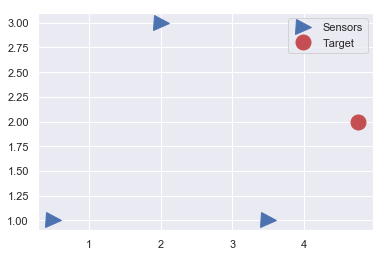

In [5]:
plt.plot(loc_info['pos_s'][:,0],loc_info['pos_s'][:,1],'b>',label='Sensors',ms=15)
plt.plot(loc_info['target'][0],loc_info['target'][1],'ro',label='Target',ms=15)
plt.legend()

### Defintion of the NNs that define the posterior mean and covariance matrix

We use a common layer and a different layer for mean and diagonal of the covariance matrix.

In [6]:
class Posterior_moments(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()

        # z_dim=2 in our 2D-localization problem, but we leave
        # as a free parameter

        # Inputs to hidden layer linear transformation
        self.hidden_mean = nn.Linear(input_dim, hidden_dim)

        self.hidden_var = nn.Linear(input_dim, hidden_dim)

        # Mean linear layer
        self.output_mean = nn.Linear(hidden_dim, z_dim)
        # Diagonal variance linear layer
        self.output_logvar = nn.Linear(hidden_dim, z_dim)

        self.activation = nn.Tanh()

    def forward(self, x):
        # Pass the input tensor through each of our operations

        mean = self.output_mean(self.activation(self.hidden_mean(x)))

        """Since variance has to be a positive value, we assume
        the network outpus the logarithm of the diagonal of the 
        covariance matrix variance"""

        log_var = self.output_logvar(self.activation(self.hidden_var(x)))
        return mean, log_var


    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, std=0.3)
                m.bias.data.zero_()

In [7]:
Qz_x = Posterior_moments( input_dim=loc_info['L']*loc_info['N'], 
                         z_dim=loc_info['z_dim'], 
                         hidden_dim=hidden_dim)

### Class to evaluate the loss function (ELBO)

Lets create a new class inherited that takes the likelihood function, prior distribution and posterior approximation and adds two functionalities: one to sample from $q(\mathbf{z}|\mathbf{X})$ and one to evaluate the ELBO

In [8]:
class Model:
    def __init__(self, Px_z, Pz, Qz_x):

        self.Qz_x = Qz_x
        self.Px_z = Px_z
        self.Pz = Pz
        
        self.z_dim = self.Px_z.z_dim

    def evaluate_log_prior(self,z):
        if type(z) == np.ndarray:
            log_prob = self.Pz.log_prob(torch.from_numpy(z).float())
            return log_prob.cpu().numpy()
        else:
            return self.Pz.log_prob(z)


    def get_q_params(self, x):
        mean, log_var = self.Qz_x(x)
        return mean.data.cpu().numpy(), log_var.data.cpu().numpy()
    def sample_from_q(self,x):
        mean, log_var = self.Qz_x(x)

        # Sampling from q(z|x).
        # We first sample from N(0,I)
        # Then, scale by std vector and sum the mean

        noise = torch.FloatTensor(x.shape[0], 1).normal_()

        sample = mean + torch.sqrt(torch.exp(log_var)) * noise
        return sample, mean, log_var


    def ELBO(self, x):

        z_q,  mean_q, log_var_q= self.sample_from_q(x)
        # KL divergence ELBO regularizer

        KL = -0.5 *self.z_dim + 0.5 * torch.sum(torch.exp(log_var_q) + mean_q ** 2 - log_var_q)

        # Evaluate log-likelihood for the current z sample
        # To do this we use the probabilistic model!

        # Signal mean per sensor


        log_lik = self.Px_z.evaluate(x, z_q)

        ELBO_loss = log_lik - KL

        return ELBO_loss, log_lik, KL


    def load_checkpoint(self, model_dict):
        self.Qz_x.load_state_dict(model_dict['state_dict_Qz_x'])
        self.z_dim = self.Px_z.z_dim


    def get_state_dict(self):
        return {'state_dict_Qz_x': self.Qz_x.state_dict()}

    def cuda(self):
        if torch.cuda.is_available():
            self.Qz_x.cuda()
    def train(self):
        self.Qz_x.train()

    def eval(self):
        self.Qz_x.eval()


    def parameters(self):
        params = list()
        params.extend(self.Qz_x.parameters())
        return params


In [9]:
# The prior distribution encoder our prior knowledge about the parameters
Pz = MultivariateNormal(torch.zeros(loc_info['z_dim']), torch.eye(loc_info['z_dim']))
model = Model(Px_z, Pz, Qz_x)

### Class to perform ELBO optimization

Create a new class that implements a method `train_step` to perform a SGD step over the variational bound (ELBO)

In [10]:
class VAE_STrainer:

    def __init__(self, model, l_rate=2e-4, beta1=0.9, beta2=0.999):
        self.model = model

        self.optimizer = torch.optim.Adam(model.parameters(), lr=l_rate, betas=(beta1, beta2))

    def train_step(self, x):
        self.optimizer.zero_grad()
        ELBO_loss, log_lik, KL = self.model.ELBO(x)
        nELBO_loss = -ELBO_loss # Multiply by -1 to minimize
        nELBO_loss.backward()
        self.optimizer.step()
        return ELBO_loss, log_lik, KL
    def train(self, x, SGD_steps,print_every=4, save_every=10):
        self.model.train()
        for i in range(SGD_steps):
            ELBO_loss, log_lik, KL = self.train_step(x)
            if i % print_every == 0:
                ELBO_loss = ELBO_loss.data.cpu().numpy()
                log_lik = log_lik.data.cpu().numpy()
                KL = KL.data.cpu().numpy()
                print('Step = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f' %(i,log_lik,KL,-ELBO_loss))



In [11]:
x_train = torch.from_numpy(X.reshape([1,-1]))
trainer = VAE_STrainer(model, l_rate=1e-2, beta1=0.7, beta2=0.999)


We fix the seed for reproducibility

In [12]:
torch.manual_seed(20)
np.random.seed(20)
trainer.train(x_train, SGD_steps=10000, print_every=1000, save_every=10)

Step = 0, loglik = -412.49805, KL = 0.10865, ELBO = 412.60669
Step = 1000, loglik = -35.21881, KL = 16.87826, ELBO = 52.09708
Step = 2000, loglik = -34.39691, KL = 18.01141, ELBO = 52.40833
Step = 3000, loglik = -34.55082, KL = 17.31024, ELBO = 51.86106
Step = 4000, loglik = -34.43998, KL = 16.20131, ELBO = 50.64129
Step = 5000, loglik = -39.89281, KL = 16.98094, ELBO = 56.87375
Step = 6000, loglik = -34.28638, KL = 21.06064, ELBO = 55.34702
Step = 7000, loglik = -36.47410, KL = 16.91054, ELBO = 53.38464
Step = 8000, loglik = -34.34887, KL = 17.75402, ELBO = 52.10289
Step = 9000, loglik = -35.24488, KL = 18.02647, ELBO = 53.27135


### Plot the results

* Get the optimal parameters of the approximated posterior distribution found during the optimization
* Generate `nsamples` from the posterior
* Plot the generated samples, the true position of the target and the position of the sensors

In [13]:
nsamples = 50
model.eval()
q_mean, q_log_var = model.get_q_params(x_train)
samples = q_mean + np.sqrt(np.exp(q_log_var)) * np.random.randn(nsamples,2)
log_prior = model.evaluate_log_prior(samples)
Plog_pxz_eval = Px_z.evaluate_join(x_train, samples, log_prior)

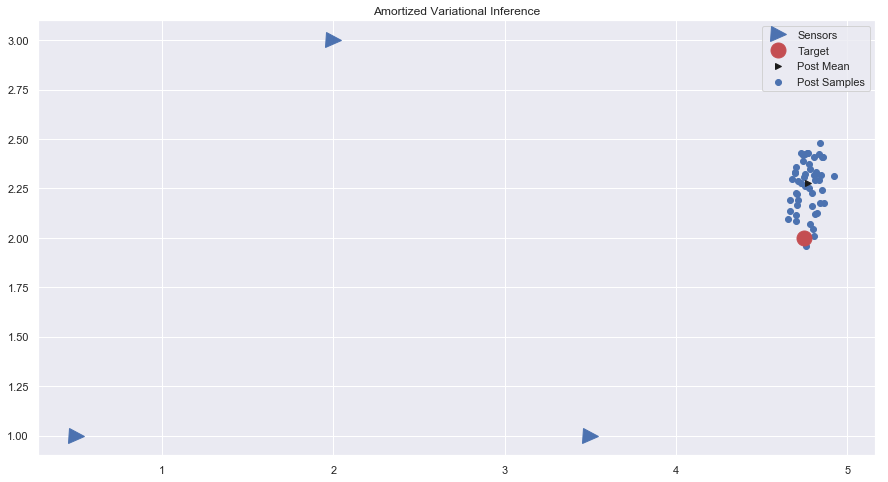

In [14]:
f = plt.figure(figsize=(15,8))

ax = plt.subplot(1, 1, 1)
ax.plot(loc_info['pos_s'][:, 0], loc_info['pos_s'][:, 1], 'b>', label='Sensors', ms=15)
ax.plot(loc_info['target'][0], loc_info['target'][1], 'ro', label='Target', ms=15)
ax.scatter(samples[:,0],samples[:,1],label='Post Samples')
ax.plot(q_mean[:, 0], q_mean[:, 1], 'k>', label='Post Mean')
ax.set_title('Amortized Variational Inference')
ax.legend()


plt.show()